<a href="https://colab.research.google.com/github/MHMotamedi97/prediction_101/blob/main/Momentum_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta
!pip install zigzag
!pip install python-binance

import os

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from binance.client import Client

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pandas_ta as ta
import numpy as np
import itertools
import datetime
import enum
import time
import enum

mpl.rcParams['agg.path.chunksize'] = 10000
pd.set_option("display.max_rows", 5000)
pd.set_option("display.precision", 5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 4.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=58917efa223089e3767aa8b7bc57c2b07d555e536a3c43a0203330e6f469dcc3
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.3 MB/s 
  Created wheel for zigzag: filename=ZigZag-0.2.2-cp37-cp37m-linux_x86_64.whl size=445983 sha256=b7c9d4fd21be077f2bed74ab88a25934d7e9a35e159f861bf78f0aabf0f2d146
  Stored in directory: /root/.cache/pip/wheels/cc/74/73/79cdb32dd48bcf66f9fcb3960a84d0f6a6cd763938bab30041
Successfully built zigzag
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Price_Prediction
%ls


/content/drive/My Drive/Price_Prediction
1Mb6ACKtFZsCC0uCI6ABltPuRQal1ZPUh             HM_Model.h5
1minute_rsi_df.csv                            HM_Model_v7.2.4_ensamble_4.h5
2022_1H.csv                                   HM_Model_v7.2.4_ensamble_8.h5
bitcoin.csv                                   HM_Model_v8/
bitcoin_data.csv                              one_year.csv
BTCUSDT_15m.csv                               prediction.xlsx
BTCUSDT_1H.csv                                random_search.xlsx
BTCUSDT_1H_timestamp_modified_continued.xlsx  real_time.xlsx
BTCUSDT_1m.csv                                rsi_complete.csv
BTCUSDT_2021.csv                              rsi_complete.csv_with_zz.csv
BTCUSDT_Jan.csv                               rsi_complete_with_zz.csv
data.xlsx                                     rsi_df.csv
ETHUSDT_15m.csv                               rsi_hourly.csv
ETHUSDT_1H.csv                                rsi_hourly_extensive.csv
ETHUSDT_1m.csv                               

### Retrieving Price Data From Exchange

In [ ]:
def pre_process(df):
    # df['Time'] = pd.to_datetime(df['Time'], unit='ms')
    df = df.filter(items=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['body'] = df['Close'] - df['Open']
    df['sign'] = (np.sign(df['body'])+1)/2
    df['sign'] = df['sign'].astype(int)
    return df

def forex_pre_process(df):
    df = df.filter(items=['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>'])
    df['body'] = df['<CLOSE>'] - df['<OPEN>']
    df['sign'] = (np.sign(df['body'])+1)/2
    df['sign'] = df['sign'].astype(int)
    return df

api_key = 'mKudn88izK1eyiUHMena8sJ9dn2kpcwLgHG2KmVgGDIHsBiaOMyTTkcTRwLWvs0g'
api_secret = 'SyAMegwr1J7UhTlIKBV6dMov4gk2xyUgvop9jLB7dvx0YZQgXUzCooLcnef2QOlD'
client = Client(api_key, api_secret)
start_time = "23 aug, 2022"
# start_time = '2022-01-01 02:00:00'
# end_time = '2022-07-05 06:00:00'
# end_time = "26 jun, 2022"
end_time = int(datetime.datetime.now(datetime.timezone.utc).replace(microsecond=0, second=0, minute=0).timestamp())*1000
# start_time = end_time - 60*60*1000*168*1

# candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1HOUR)
# candles = client.get_historical_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE, start_str=start_time, end_str=end_time)
candles = client.get_historical_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1HOUR, start_str=start_time, end_str=end_time)
candles = pd.DataFrame(candles, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume','a','b','c','d','e','f'])
candles = candles.filter(items=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
candles['Time'] = pd.to_datetime(candles['Time'],unit='ms')
candles['Open'] = candles['Open'].astype(np.float64)
candles['High'] = candles['High'].astype(np.float64)
candles['Low'] = candles['Low'].astype(np.float64)
candles['Close'] = candles['Close'].astype(np.float64)
candles['Volume'] = candles['Volume'].astype(np.float64)
candles = pre_process(candles)
candles

Time      Open      High       Low     Close       Volume  \
0   2022-08-23 00:00:00  21400.75  21468.51  21285.02  21303.25   9264.93160   
1   2022-08-23 01:00:00  21303.25  21407.59  21290.39  21306.86   5897.83057   
2   2022-08-23 02:00:00  21306.86  21360.00  21260.05  21347.38   5115.81528   
3   2022-08-23 03:00:00  21347.38  21376.99  21218.28  21239.18   5281.51877   
4   2022-08-23 04:00:00  21239.18  21318.84  21224.85  21265.60   4982.14947   
5   2022-08-23 05:00:00  21265.60  21289.13  20932.37  20965.89  10353.28286   
6   2022-08-23 06:00:00  20964.10  21091.37  20890.14  21083.26   8972.01842   
7   2022-08-23 07:00:00  21081.57  21309.98  21067.70  21305.34  10108.60965   
8   2022-08-23 08:00:00  21305.34  21519.01  21301.61  21450.00  13184.72367   
9   2022-08-23 09:00:00  21450.86  21550.00  21286.00  21442.58  11705.57539   
10  2022-08-23 10:00:00  21442.58  21460.57  21314.49  21416.39   8741.20005   
11  2022-08-23 11:00:00  21417.46  21495.00  21348.19  21456.34   7286.42398   
12  2022-08-23 12:00:00  21455.97  21518.34  21334.28  21350.98   7934.20437   
13  2022-08-23 13:00:00  21350.98  21598.00  21327.95  21520.58  13989.26256   
14  2022-08-23 14:00:00  21518.52  21684.87  21441.55  21468.15  16046.27479   
15  2022-08-23 15:00:00  21469.37  21582.16  21383.55  21474.67  10905.26018   
16  2022-08-23 16:00:00  21473.01  21483.71  21358.38  21462.75   8719.37221   
17  2022-08-23 17:00:00  21462.75  21519.90  21392.84  21414.72   6651.78986   
18  2022-08-23 18:00:00  21414.72  21602.49  21394.19  21543.77   8645.81100   
19  2022-08-23 19:00:00  21543.77  21578.00  21486.75  21522.01   5849.95942   
20  2022-08-23 20:00:00  21522.01  21654.91  21454.86  21478.35   6451.33095   
21  2022-08-23 21:00:00  21479.51  21510.00  21428.00  21489.36   2957.91070   
22  2022-08-23 22:00:00  21489.36  21588.97  21471.25  21475.50   6154.97813   
23  2022-08-23 23:00:00  21475.71  21605.44  21455.11  21529.12   5767.53776   
24  2022-08-24 00:00:00  21529.11  21555.84  21332.80  21385.79   8032.00919   
25  2022-08-24 01:00:00  21385.79  21431.22  21172.48  21264.71   8089.45150   
26  2022-08-24 02:00:00  21264.71  21368.08  21145.00  21200.06   7771.60019   
27  2022-08-24 03:00:00  21200.06  21291.19  21167.58  21264.01   5892.87163   
28  2022-08-24 04:00:00  21264.01  21362.77  21237.57  21328.56   4919.42586   
29  2022-08-24 05:00:00  21329.47  21504.97  21311.49  21421.18   8434.11364   
30  2022-08-24 06:00:00  21421.18  21469.86  21318.09  21404.55   6746.25286   
31  2022-08-24 07:00:00  21404.55  21452.00  21243.29  21317.85   9573.76912   
32  2022-08-24 08:00:00  21319.27  21440.07  21300.00  21341.40   7185.92744   
33  2022-08-24 09:00:00  21341.40  21397.20  21293.39  21314.67   5646.55573   
34  2022-08-24 10:00:00  21314.67  21385.01  21261.00  21282.16   5679.76892   
35  2022-08-24 11:00:00  21282.16  21476.23  21271.64  21438.92   7089.80780   
36  2022-08-24 12:00:00  21439.84  21512.00  21421.22  21486.75   8392.54188   
37  2022-08-24 13:00:00  21485.60  21508.53  21373.43  21439.86   9335.99877   
38  2022-08-24 14:00:00  21438.62  21558.00  21400.01  21467.61   9331.63610   
39  2022-08-24 15:00:00  21467.61  21645.65  21452.82  21618.45   9474.22124   
40  2022-08-24 16:00:00  21618.46  21900.00  21609.09  21717.89  13574.70464   
41  2022-08-24 17:00:00  21719.06  21781.89  21605.00  21633.24   7172.13213   
42  2022-08-24 18:00:00  21633.24  21731.22  21624.02  21674.91   5183.34812   
43  2022-08-24 19:00:00  21674.91  21809.00  21672.00  21707.58   6177.85231   
44  2022-08-24 20:00:00  21709.32  21761.92  21677.31  21691.93   4379.21230   
45  2022-08-24 21:00:00  21691.93  21720.00  21554.00  21592.07   3270.55376   
46  2022-08-24 22:00:00  21590.77  21655.50  21450.00  21493.73   7954.92987   
47  2022-08-24 23:00:00  21492.91  21532.99  21361.60  21368.08   5074.53546   
48  2022-08-25 00:00:00  21368.05  21488.68  21310.15  21481.32   7688.96129   
49  2022-08-25 01:0

In [ ]:
# gbpusd = pd.read_excel('/content/bit.xlsx', sheet_name='hourly_futures')
# gbpusd = pd.read_table('GBPUSD_H1_201501050000_202201282300.csv')

# df = forex_pre_process(gbpusd)
# df = pre_process(candles)
df = candles

# df = gbpusd.iloc[::-1]
# df = gbpusd
# df.columns=['Open', 'High', 'Low', 'Close', 'body', 'sign']
# df = df.filter(items=['Datetime', 'open_price', 'close_price', 'close_prediction'])
# df = df.drop(columns=['model'])
# df['high_price'] = candles['High']
# df['low_price'] = candles['Low']
# df['sign'] = np.sign(df['close_price'] - df['open_price'])
# df['body'] = df['close_price'] - df['open_price']
df.to_csv('last_week.csv',index=None)

### Indicators Calculation


In [ ]:
df.ta.fisher(append=True)
df.ta.atr(append=True)
df.ta.rsi(append=True)
df.ta.adx(append=True)
df = df.dropna()
df = df.reset_index().drop(columns=['index'])
# df = df.drop(columns=['index', 'level_0'])
df


Time      Open      High       Low     Close        Volume  \
0    2017-09-13   4159.72   4165.38   3760.00   3944.69     913.46254   
1    2017-09-14   3944.00   3993.00   3165.13   3189.02    1665.02154   
2    2017-09-15   3188.01   3856.00   2817.00   3700.00    1968.86649   
3    2017-09-16   3674.01   3950.00   3470.66   3714.95    1297.56395   
4    2017-09-17   3685.23   3748.21   3499.02   3699.99     682.17121   
5    2017-09-18   3690.00   4123.20   3690.00   4035.01    1030.00645   
6    2017-09-19   4060.00   4089.97   3830.91   3910.04     902.33213   
7    2017-09-20   3910.04   4046.08   3820.00   3900.00     720.93508   
8    2017-09-21   3889.99   3910.00   3567.00   3609.99    1001.65408   
9    2017-09-22   3592.84   3750.00   3505.55   3595.87     838.96642   
10   2017-09-23   3595.88   3817.19   3542.91   3780.00     752.79279   
11   2017-09-24   3779.54   3789.99   3622.76   3660.02     661.63639   
12   2017-09-25   3660.02   3979.87   3653.69   3920.75     727.99471   
13   2017-09-26   3928.00   3976.99   3850.05   3882.35     526.72799   
14   2017-09-27   3882.36   4249.94   3872.81   4193.00     628.17097   
15   2017-09-28   4192.11   4300.00   4101.00   4174.50     849.78532   
16   2017-09-29   4178.98   4263.86   3952.01   4174.69    1602.30957   
17   2017-09-30   4175.00   4380.00   4138.10   4378.51     720.35318   
18   2017-10-01   4378.49   4406.52   4240.04   4378.48     726.96369   
19   2017-10-02   4400.00   4561.63   4360.00   4380.00     655.75697   
20   2017-10-03   4380.00   4467.33   4180.80   4310.00    1082.32356   
21   2017-10-04   4314.90   4373.00   4142.00   4208.59     868.46510   
22   2017-10-05   4208.59   4355.00   4110.00   4292.43     779.13864   
23   2017-10-06   4318.99   4417.00   4292.00   4369.00     506.52918   
24   2017-10-07   4369.00   4479.50   4312.56   4423.00     297.59750   
25   2017-10-08   4425.00   4658.00   4425.00   4640.00     518.46200   
26   2017-10-09   4640.00   4889.98   4550.00   4786.95     646.46315   
27   2017-10-10   4786.95   4960.00   4680.59   4783.06    1043.22177   
28   2017-10-11   4783.06   4881.61   4710.00   4821.43     753.42940   
29   2017-10-12   4821.43   5439.99   4810.16   5430.00    1276.70148   
30   2017-10-13   5439.99   5846.17   5379.84   5649.98    1879.82762   
31   2017-10-14   5650.00   5900.00   5580.01   5869.99     970.75905   
32   2017-10-15   5855.03   5922.30   5400.01   5709.99    1343.52337   
33   2017-10-16   5710.00   5788.91   5585.19   5760.02    1528.99646   
34   2017-10-17   5760.00   5774.98   5508.63   5595.00    1429.86938   
35   2017-10-18   5595.00   5596.00   5037.95   5512.06    2317.80437   
36   2017-10-19   5513.00   5710.00   5490.26   5683.90    1881.72211   
37   2017-10-20   5683.31   6110.00   5600.00   6010.01    1972.97722   
38   2017-10-21   6013.72   6171.00   5850.03   6024.97    1664.30769   
39   2017-10-22   6003.27   6060.00   5720.03   5950.02    1362.09222   
40   2017-10-23   5975.00   6080.00   5621.03   5915.93    1812.55771   
41   2017-10-24   5909.47   5925.00   5450.00   5477.03    2580.41877   
42   2017-10-25   5506.92   5704.96   5286.98   5689.99    2282.81320   
43   2017-10-26   5670.10   5939.99   5650.00   5861.77    1972.96588   
44   2017-10-27   5861.77   5980.00   5649.24   5768.83    1403.70642   
45   2017-10-28   5768.79   5850.02   5630.03   5719.64    1276.75441   
46   2017-10-29   5709.98   6189.88   5648.01   6169.98    1804.77817   
47   2017-10-30   6133.01   6248.68   6030.00   6120.50    1473.68704   
48   2017-10-31   6120.52   6498.01   6100.00   6463.00    1511.77492   
49   2017-11-01   6463.00   6774.67   6338.02   6753.98    1675.61519   
50   2017-11-02   6753.98   7300.00   6685.10   7019.98    2503.61080   
51   2017-11-03   7010.31   7346.34   6923.00   7115.04    1891.49759   
52   2017-11-04   7115.02   7480.99   6901.00   7357.09    1399.19177   
53   2017-11-05   7357.27   7590.25   7279.02   7345.01    1207.83233

### Classification of Price data with zigzag Indicator

In [ ]:
# labeling data by zigzag indicator
from zigzag import peak_valley_pivots
def plot_pivots(X, pivots):
    plt.xlim(-100, len(X)+100)
    plt.ylim(X.min()*0.9, X.max()*1.1)
    plt.plot(np.arange(len(X)), X, alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

pivots_5 = peak_valley_pivots(df['Close'].values, 0.005, -0.005)
# pivots_10 = peak_valley_pivots(df['Close'].values, 0.01, -0.01)
# pivots_15 = peak_valley_pivots(df['Close'].values, 0.015, -0.015)
# pivots_20 = peak_valley_pivots(df['Close'].values, 0.02, -0.02)
# pivots_25 = peak_valley_pivots(df['Close'].values, 0.025, -0.025)

df['zigzag_5'] = pivots_5
# df['zigzag_10'] = pivots_10
# df['zigzag_15'] = pivots_15
# df['zigzag_20'] = pivots_20
# df['zigzag_25'] = pivots_25

# df['zigzag_5'] = df['zigzag_5'].replace(['L', 'S'], [-1, 1])
# df['zigzag_5'] = df['zigzag_5'].replace([-1, 1, 0], [1, 0, np.nan])
# # df['zigzag_10'] = df['zigzag_10'].replace([-1, 1, 0], ['L', 'S', np.nan])
# # df['zigzag_15'] = df['zigzag_15'].replace([-1, 1, 0], ['L', 'S', np.nan])
# # df['zigzag_20'] = df['zigzag_20'].replace([-1, 1, 0], ['L', 'S', np.nan])
# # df['zigzag_25'] = df['zigzag_25'].replace([-1, 1, 0], ['L', 'S', np.nan])
# df = df.fillna(method='ffill')
# # df['zigzag_5'] = df['zigzag_5'].replace(['L', 'S'], [1, 0])
# df = df.dropna()
# df = df.reset_index()
df.head(60)



Time     Open     High      Low    Close    Volume    body  \
0  2017-08-18 07:00:00  4279.46  4304.67  4270.48  4300.25  69.18680   20.79   
1  2017-08-18 08:00:00  4285.00  4320.71  4259.85  4282.73  74.82985   -2.27   
2  2017-08-18 09:00:00  4265.33  4327.25  4265.33  4304.15  45.65316   38.82   
3  2017-08-18 10:00:00  4304.15  4371.52  4296.04  4356.31  51.56368   52.16   
4  2017-08-18 11:00:00  4356.31  4357.37  4302.72  4340.31  24.09345  -16.00   
5  2017-08-18 12:00:00  4320.52  4340.31  4287.79  4331.71  15.11896   11.19   
6  2017-08-18 13:00:00  4302.97  4318.16  4221.05  4293.09  46.53377   -9.88   
7  2017-08-18 14:00:00  4293.09  4293.09  4193.70  4259.40  74.36894  -33.69   
8  2017-08-18 15:00:00  4259.40  4259.40  4200.00  4236.89  39.94772  -22.51   
9  2017-08-18 16:00:00  4234.54  4283.79  4234.54  4250.34  45.03882   15.80   
10 2017-08-18 17:00:00  4250.34  4250.34  4066.53  4193.35  62.69147  -56.99   
11 2017-08-18 18:00:00  4171.17  4297.75  4117.41  4117.41  25.31865  -53.76   
12 2017-08-18 19:00:00  4086.28  4136.48  4015.70  4136.28  60.59803   50.00   
13 2017-08-18 20:00:00  4135.00  4135.00  3981.13  4021.11  19.96804 -113.89   
14 2017-08-18 21:00:00  4015.40  4015.40  3938.77  3975.69  14.73863  -39.71   
15 2017-08-18 22:00:00  3996.92  4131.83  3938.77  4113.75  29.90620  116.83   
16 2017-08-18 23:00:00  4106.35  4136.48  4085.88  4108.37  44.93684    2.02   
17 2017-08-19 00:00:00  4108.37  4178.31  4084.28  4163.49  41.30888   55.12   
18 2017-08-19 01:00:00  4163.49  4184.69  4143.11  4148.53  28.83518  -14.96   
19 2017-08-19 02:00:00  4148.53  4184.00  4148.53  4156.39  18.75447    7.86   
20 2017-08-19 03:00:00  4180.00  4180.00  4103.52  4138.55  19.61192  -41.45   
21 2017-08-19 04:00:00  4138.50  4156.00  4046.26  4068.26  17.35323  -70.24   
22 2017-08-19 05:00:00  4123.95  4123.95  4027.83  4077.00  12.51419  -46.95   
23 2017-08-19 06:00:00  4077.00  4082.00  3986.87  3986.87  51.45543  -90.13   
24 2017-08-19 07:00:00  3969.12  4033.47  3933.21  4033.47  31.42922   64.35   
25 2017-08-19 08:00:00  4033.47  4064.84  3964.08  3999.00  18.00641  -34.47   
26 2017-08-19 09:00:00  3999.00  4082.25  3999.00  4068.20   5.18422   69.20   
27 2017-08-19 10:00:00  4054.00  4082.00  3982.08  4000.58   5.88683  -53.42   
28 2017-08-19 11:00:00  4016.00  4033.00  3850.00  3957.60  48.17858  -58.40   
29 2017-08-19 12:00:00  3945.12  4095.00  3928.89  4095.00  22.23098  149.88   
30 2017-08-19 13:00:00  4095.00  4100.00  4035.49  4039.84  12.70566  -55.16   
31 2017-08-19 14:00:00  4066.00  4068.31  4013.70  4042.41   4.33443  -23.59   
32 2017-08-19 15:00:00  4036.59  4063.44  3964.67  3972.05   8.24450  -64.54   
33 2017-08-19 16:00:00  4036.19  4049.69  3953.40  4000.00   4.08418  -36.19   
34 2017-08-19 17:00:00  3985.00  4048.99  3976.72  4027.37   3.06955   42.37   
35 2017-08-19 18:00:00  4013.69  4096.00  4013.69  4086.29  17.14820   72.60   
36 2017-08-19 19:00:00  4073.47  4103.92  4073.47  4076.12   1.62313    2.65   
37 2017-08-19 20:00:00  4088.71  4103.92  4051.47  4075.98   2.98757  -12.73   
38 2017-08-19 21:00:00  4075.98  4149.99  4074.23  4074.23   3.95219   -1.75   
39 2017-08-19 22:00:00  4090.00  4141.00  4090.00  4139.98   2.35810   49.98   
40 2017-08-19 23:00:00  4120.78  4139.98  4120.78  4139.98   0.05270   19.20   
41 2017-08-20 00:00:00  4120.98  4139.98  4044.00  4086.09   2.34392  -34.89   
42 2017-08-20 01:00:00  4086.09  4086.09  4052.82  4082.53   1.06115   -3.56   
43 2017-08-20 02:00:00  4096.33  4124.69  4082.62  4124.69   2.85856   28.36   
44 2017-08-20 03:00:00  4111.26  4111.26  4094.62  4094.62   0.34765  -16.64   
45 2017-08-20 04:00:00  4094.62  4094.62  4091.80  4093.00   0.80924   -1.62   
46 2017-08-20 05:00:00  4087.00  4142.16  4087.00  4117.41  10.74306   30.41   
47 2017-08-20 06:00:00  4117.41  4117.41  4081.19  4115.41   2.91555   -2.00   
48 2017-08-20 07:00:00  4081.40  4156.56  4081.40  4155.87  14.13606   74.47   
49 2017-08-20 08:0

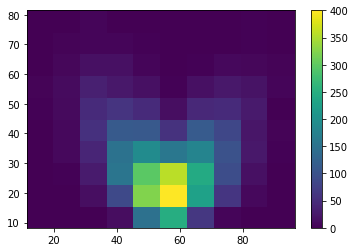

In [ ]:
# df[df.zigzag_5==-1]['ADX_14'].hist()
plt.hist2d(df[df.zigzag_5==1]['RSI_14'], df[df.zigzag_5==1]['ADX_14'], bins=(10, 10), vmax=400)
plt.colorbar()
# df.head(60)
# df.index = df['Time']


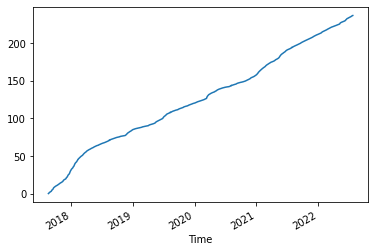

In [ ]:
from collections import defaultdict
# backtest = df[df.ADX_14 > 15]
# backtest = backtest[backtest.ADX_14 < 50]
# backtest = backtest[backtest.RSI_14 < 70]
# backtest = backtest[backtest.RSI_14 > 40]
# backtest = candles
# tmp1 = np.sign(backtest['close_prediction'] - backtest['open_price'])
# tmp2 = np.sign(backtest['close_price'] - backtest['open_price'])
# backtest['prediction_accuracy'] = backtest['sign']*backtest['predicted']

acc = 1
backtest['prediction_accuracy'] = np.random.choice([-1, 1], 43197, p=[1-acc, acc])

backtest['sign'] = backtest['sign'].replace([0, 1], [-1, 1], inplace=False)
backtest['profit'] = np.abs(backtest['body'])*backtest['prediction_accuracy']
# backtest['profit'] = np.abs(backtest['body'])
backtest['balance'] = np.cumsum(backtest['profit'])
# backtest.index = backtest['Time']
backtest = backtest.set_index(backtest['Time'])

# backtest['balance'].plot()
# backtest['sign'].rolling(2).mean().value_counts()
# backtest['Close'].mean()

# max_drawdown(backtest['balance'].values)
# accuracy_score(backtest['sign'], backtest['predicted'])

# (backtest['prediction_accuracy'].sum()+np.abs(backtest['prediction_accuracy']).sum())/2
# backtest['percent'] = backtest['profit']/backtest['Close']
backtest['percent_balance'] = np.cumsum(backtest['percent'])
backtest['percent_balance'].plot()

In [ ]:
# x['RSI_14'] = df['RSI_14']
# df['RSI_14'].iloc[134028]
# x
df

Time      Open      High       Low     Close        Volume  \
0    2017-09-13   4159.72   4165.38   3760.00   3944.69     913.46254   
1    2017-09-14   3944.00   3993.00   3165.13   3189.02    1665.02154   
2    2017-09-15   3188.01   3856.00   2817.00   3700.00    1968.86649   
3    2017-09-16   3674.01   3950.00   3470.66   3714.95    1297.56395   
4    2017-09-17   3685.23   3748.21   3499.02   3699.99     682.17121   
5    2017-09-18   3690.00   4123.20   3690.00   4035.01    1030.00645   
6    2017-09-19   4060.00   4089.97   3830.91   3910.04     902.33213   
7    2017-09-20   3910.04   4046.08   3820.00   3900.00     720.93508   
8    2017-09-21   3889.99   3910.00   3567.00   3609.99    1001.65408   
9    2017-09-22   3592.84   3750.00   3505.55   3595.87     838.96642   
10   2017-09-23   3595.88   3817.19   3542.91   3780.00     752.79279   
11   2017-09-24   3779.54   3789.99   3622.76   3660.02     661.63639   
12   2017-09-25   3660.02   3979.87   3653.69   3920.75     727.99471   
13   2017-09-26   3928.00   3976.99   3850.05   3882.35     526.72799   
14   2017-09-27   3882.36   4249.94   3872.81   4193.00     628.17097   
15   2017-09-28   4192.11   4300.00   4101.00   4174.50     849.78532   
16   2017-09-29   4178.98   4263.86   3952.01   4174.69    1602.30957   
17   2017-09-30   4175.00   4380.00   4138.10   4378.51     720.35318   
18   2017-10-01   4378.49   4406.52   4240.04   4378.48     726.96369   
19   2017-10-02   4400.00   4561.63   4360.00   4380.00     655.75697   
20   2017-10-03   4380.00   4467.33   4180.80   4310.00    1082.32356   
21   2017-10-04   4314.90   4373.00   4142.00   4208.59     868.46510   
22   2017-10-05   4208.59   4355.00   4110.00   4292.43     779.13864   
23   2017-10-06   4318.99   4417.00   4292.00   4369.00     506.52918   
24   2017-10-07   4369.00   4479.50   4312.56   4423.00     297.59750   
25   2017-10-08   4425.00   4658.00   4425.00   4640.00     518.46200   
26   2017-10-09   4640.00   4889.98   4550.00   4786.95     646.46315   
27   2017-10-10   4786.95   4960.00   4680.59   4783.06    1043.22177   
28   2017-10-11   4783.06   4881.61   4710.00   4821.43     753.42940   
29   2017-10-12   4821.43   5439.99   4810.16   5430.00    1276.70148   
30   2017-10-13   5439.99   5846.17   5379.84   5649.98    1879.82762   
31   2017-10-14   5650.00   5900.00   5580.01   5869.99     970.75905   
32   2017-10-15   5855.03   5922.30   5400.01   5709.99    1343.52337   
33   2017-10-16   5710.00   5788.91   5585.19   5760.02    1528.99646   
34   2017-10-17   5760.00   5774.98   5508.63   5595.00    1429.86938   
35   2017-10-18   5595.00   5596.00   5037.95   5512.06    2317.80437   
36   2017-10-19   5513.00   5710.00   5490.26   5683.90    1881.72211   
37   2017-10-20   5683.31   6110.00   5600.00   6010.01    1972.97722   
38   2017-10-21   6013.72   6171.00   5850.03   6024.97    1664.30769   
39   2017-10-22   6003.27   6060.00   5720.03   5950.02    1362.09222   
40   2017-10-23   5975.00   6080.00   5621.03   5915.93    1812.55771   
41   2017-10-24   5909.47   5925.00   5450.00   5477.03    2580.41877   
42   2017-10-25   5506.92   5704.96   5286.98   5689.99    2282.81320   
43   2017-10-26   5670.10   5939.99   5650.00   5861.77    1972.96588   
44   2017-10-27   5861.77   5980.00   5649.24   5768.83    1403.70642   
45   2017-10-28   5768.79   5850.02   5630.03   5719.64    1276.75441   
46   2017-10-29   5709.98   6189.88   5648.01   6169.98    1804.77817   
47   2017-10-30   6133.01   6248.68   6030.00   6120.50    1473.68704   
48   2017-10-31   6120.52   6498.01   6100.00   6463.00    1511.77492   
49   2017-11-01   6463.00   6774.67   6338.02   6753.98    1675.61519   
50   2017-11-02   6753.98   7300.00   6685.10   7019.98    2503.61080   
51   2017-11-03   7010.31   7346.34   6923.00   7115.04    1891.49759   
52   2017-11-04   7115.02   7480.99   6901.00   7357.09    1399.19177   
53   2017-11-05   7357.27   7590.25   7279.02   7345.01    1207.83233

### Momentum Patterns with Fisher

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')
rsi_df = df.filter(items=['FISHERT_9_1', 'FISHERTs_9_1', 'ATRr_14', 'RSI_14'])
# rsi_df = df.filter(items=['rsi_3', 'rsi_5', 'rsi_15', 'rsi_30', 'rsi_60', 'rsi_120', 'rsi_240', 'rsi_360', 'rsi_480', 'rsi_720'])

modified_df = df.drop(columns=['FISHERT_9_1', 'FISHERTs_9_1', 'ATRr_14', 'RSI_14'])
print(modified_df)
tic = time.time()
pca.fit(rsi_df.head(-200))
tac =  time.time()
print(tac - tic)
print(rsi_df)
rsi_df = pd.DataFrame(pca.transform(rsi_df))
rsi_df.columns=['feature_1', 'feature_2'] #, 'feature_3', 'feature_4', 'feature_5']
rsi_df
modified_df['feature_1'] = rsi_df['feature_1']
modified_df['feature_2'] = rsi_df['feature_2']
# modified_df['feature_3'] = rsi_df['feature_3']
# modified_df['feature_4'] = rsi_df['feature_4']
# modified_df['feature_5'] = rsi_df['feature_5']
# modified_df = modified_df.dropna()
modified_df
# pca.transform(rsi_df)
# rsi_df


Streaming output truncated to the last 5000 lines.
341  2018-08-20   6477.53   6530.00   6220.00   6254.84   49435.55526   
342  2018-08-21   6251.00   6500.00   6235.08   6480.00   41569.94741   
343  2018-08-22   6479.98   6882.54   6251.20   6360.89   77909.39136   
344  2018-08-23   6362.57   6576.99   6342.28   6525.01   40358.16683   
345  2018-08-24   6525.00   6725.00   6440.50   6681.64   38305.67532   
346  2018-08-25   6686.98   6789.00   6650.61   6733.64   19220.50593   
347  2018-08-26   6733.64   6775.27   6568.00   6700.00   20107.29721   
348  2018-08-27   6700.00   6940.51   6646.50   6908.64   37747.07875   
349  2018-08-28   6907.26   7135.00   6860.00   7076.11   48352.91716   
350  2018-08-29   7077.00   7133.81   6912.34   7031.22   43252.48739   
351  2018-08-30   7033.21   7063.63   6784.81   6984.84   44716.77462   
352  2018-08-31   6984.84   7089.00   6888.00   7011.21   40467.40064   
353  2018-09-01   7011.21   7275.00   7008.74   7200.01   40323.41409   


Time      Open      High       Low     Close        Volume  \
0    2017-09-13   4159.72   4165.38   3760.00   3944.69     913.46254   
1    2017-09-14   3944.00   3993.00   3165.13   3189.02    1665.02154   
2    2017-09-15   3188.01   3856.00   2817.00   3700.00    1968.86649   
3    2017-09-16   3674.01   3950.00   3470.66   3714.95    1297.56395   
4    2017-09-17   3685.23   3748.21   3499.02   3699.99     682.17121   
5    2017-09-18   3690.00   4123.20   3690.00   4035.01    1030.00645   
6    2017-09-19   4060.00   4089.97   3830.91   3910.04     902.33213   
7    2017-09-20   3910.04   4046.08   3820.00   3900.00     720.93508   
8    2017-09-21   3889.99   3910.00   3567.00   3609.99    1001.65408   
9    2017-09-22   3592.84   3750.00   3505.55   3595.87     838.96642   
10   2017-09-23   3595.88   3817.19   3542.91   3780.00     752.79279   
11   2017-09-24   3779.54   3789.99   3622.76   3660.02     661.63639   
12   2017-09-25   3660.02   3979.87   3653.69   3920.75     727.99471   
13   2017-09-26   3928.00   3976.99   3850.05   3882.35     526.72799   
14   2017-09-27   3882.36   4249.94   3872.81   4193.00     628.17097   
15   2017-09-28   4192.11   4300.00   4101.00   4174.50     849.78532   
16   2017-09-29   4178.98   4263.86   3952.01   4174.69    1602.30957   
17   2017-09-30   4175.00   4380.00   4138.10   4378.51     720.35318   
18   2017-10-01   4378.49   4406.52   4240.04   4378.48     726.96369   
19   2017-10-02   4400.00   4561.63   4360.00   4380.00     655.75697   
20   2017-10-03   4380.00   4467.33   4180.80   4310.00    1082.32356   
21   2017-10-04   4314.90   4373.00   4142.00   4208.59     868.46510   
22   2017-10-05   4208.59   4355.00   4110.00   4292.43     779.13864   
23   2017-10-06   4318.99   4417.00   4292.00   4369.00     506.52918   
24   2017-10-07   4369.00   4479.50   4312.56   4423.00     297.59750   
25   2017-10-08   4425.00   4658.00   4425.00   4640.00     518.46200   
26   2017-10-09   4640.00   4889.98   4550.00   4786.95     646.46315   
27   2017-10-10   4786.95   4960.00   4680.59   4783.06    1043.22177   
28   2017-10-11   4783.06   4881.61   4710.00   4821.43     753.42940   
29   2017-10-12   4821.43   5439.99   4810.16   5430.00    1276.70148   
30   2017-10-13   5439.99   5846.17   5379.84   5649.98    1879.82762   
31   2017-10-14   5650.00   5900.00   5580.01   5869.99     970.75905   
32   2017-10-15   5855.03   5922.30   5400.01   5709.99    1343.52337   
33   2017-10-16   5710.00   5788.91   5585.19   5760.02    1528.99646   
34   2017-10-17   5760.00   5774.98   5508.63   5595.00    1429.86938   
35   2017-10-18   5595.00   5596.00   5037.95   5512.06    2317.80437   
36   2017-10-19   5513.00   5710.00   5490.26   5683.90    1881.72211   
37   2017-10-20   5683.31   6110.00   5600.00   6010.01    1972.97722   
38   2017-10-21   6013.72   6171.00   5850.03   6024.97    1664.30769   
39   2017-10-22   6003.27   6060.00   5720.03   5950.02    1362.09222   
40   2017-10-23   5975.00   6080.00   5621.03   5915.93    1812.55771   
41   2017-10-24   5909.47   5925.00   5450.00   5477.03    2580.41877   
42   2017-10-25   5506.92   5704.96   5286.98   5689.99    2282.81320   
43   2017-10-26   5670.10   5939.99   5650.00   5861.77    1972.96588   
44   2017-10-27   5861.77   5980.00   5649.24   5768.83    1403.70642   
45   2017-10-28   5768.79   5850.02   5630.03   5719.64    1276.75441   
46   2017-10-29   5709.98   6189.88   5648.01   6169.98    1804.77817   
47   2017-10-30   6133.01   6248.68   6030.00   6120.50    1473.68704   
48   2017-10-31   6120.52   6498.01   6100.00   6463.00    1511.77492   
49   2017-11-01   6463.00   6774.67   6338.02   6753.98    1675.61519   
50   2017-11-02   6753.98   7300.00   6685.10   7019.98    2503.61080   
51   2017-11-03   7010.31   7346.34   6923.00   7115.04    1891.49759   
52   2017-11-04   7115.02   7480.99   6901.00   7357.09    1399.19177   
53   2017-11-05   7357.27   7590.25   7279.02   7345.01    1207.83233

In [ ]:
train, test = train_test_split(modified_df, test_size=0.15, random_state=42, shuffle=False)
# train, test = train_test_split(df, test_size=0.15, random_state=42, shuffle=False)
# test = test.dropna()
# train = df
look_back = 1
##########################################################################################
# dataX, dataY = [], []
# for i in range(train.shape[0]-look_back-1):
#     c = train['body'].iloc[i:(i+look_back)]
#     dataX.append(c)
#     dataY.append(train['sign'].iloc[i + look_back])
# x_train = np.array(dataX)
# y_train = np.array(dataY)

# dataX, dataY = [], []
# for i in range(test.shape[0]-look_back-1):
#     c = test['body'].iloc[i:(i+look_back)]
#     dataX.append(c)
#     dataY.append(test['sign'].iloc[i + look_back])
# x_test = np.array(dataX)
# y_test = np.array(dataY)
##########################################################################################

dataX, dataY = [], []
for i in range(train.shape[0]-look_back-1):
    c1 = train['body'].iloc[i:(i+look_back)]
    c2 = train['feature_1'].iloc[i:(i+look_back)]
    c3 = train['feature_2'].iloc[i:(i+look_back)]
    # c4 = train['Day sin'].iloc[i:(i+look_back)]
    dataX.append(np.array([c1, c2, c3]))#, c4, c5, c6, c7, c8, c9, c10, c11, c12]))
    dataY.append(train['sign'].iloc[i + look_back])
x_train = np.array(dataX)
y_train = np.array(dataY)

dataX, dataY = [], []
for i in range(test.shape[0]-look_back-1):
    c1 = test['body'].iloc[i:(i+look_back)]
    c2 = test['feature_1'].iloc[i:(i+look_back)]
    c3 = test['feature_2'].iloc[i:(i+look_back)]
    # c4 = train['Day sin'].iloc[i:(i+look_back)]
    dataX.append(np.array([c1, c2, c3]))#, c4, c5, c6, c7, c8, c9, c10, c11, c12]))
    dataY.append(test['sign'].iloc[i + look_back])
x_test = np.array(dataX)
y_test = np.array(dataY)

# x_train = tf.convert_to_tensor(np.reshape(x_train, (x_train.shape[0], 8, x_train.shape[1])))
# x_test = tf.convert_to_tensor(np.reshape(x_test, (x_test.shape[0], 8, x_test.shape[1])))
y_train = tf.convert_to_tensor(y_train.reshape((y_train.size, 1)))
y_test = tf.convert_to_tensor(y_test.reshape((y_test.size, 1)))

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
# y_train = tf.convert_to_tensor(y_train)
# y_test = tf.convert_to_tensor(y_test)


In [ ]:
train

Time      Open      High       Low     Close        Volume  \
0    2017-09-13   4159.72   4165.38   3760.00   3944.69     913.46254   
1    2017-09-14   3944.00   3993.00   3165.13   3189.02    1665.02154   
2    2017-09-15   3188.01   3856.00   2817.00   3700.00    1968.86649   
3    2017-09-16   3674.01   3950.00   3470.66   3714.95    1297.56395   
4    2017-09-17   3685.23   3748.21   3499.02   3699.99     682.17121   
5    2017-09-18   3690.00   4123.20   3690.00   4035.01    1030.00645   
6    2017-09-19   4060.00   4089.97   3830.91   3910.04     902.33213   
7    2017-09-20   3910.04   4046.08   3820.00   3900.00     720.93508   
8    2017-09-21   3889.99   3910.00   3567.00   3609.99    1001.65408   
9    2017-09-22   3592.84   3750.00   3505.55   3595.87     838.96642   
10   2017-09-23   3595.88   3817.19   3542.91   3780.00     752.79279   
11   2017-09-24   3779.54   3789.99   3622.76   3660.02     661.63639   
12   2017-09-25   3660.02   3979.87   3653.69   3920.75     727.99471   
13   2017-09-26   3928.00   3976.99   3850.05   3882.35     526.72799   
14   2017-09-27   3882.36   4249.94   3872.81   4193.00     628.17097   
15   2017-09-28   4192.11   4300.00   4101.00   4174.50     849.78532   
16   2017-09-29   4178.98   4263.86   3952.01   4174.69    1602.30957   
17   2017-09-30   4175.00   4380.00   4138.10   4378.51     720.35318   
18   2017-10-01   4378.49   4406.52   4240.04   4378.48     726.96369   
19   2017-10-02   4400.00   4561.63   4360.00   4380.00     655.75697   
20   2017-10-03   4380.00   4467.33   4180.80   4310.00    1082.32356   
21   2017-10-04   4314.90   4373.00   4142.00   4208.59     868.46510   
22   2017-10-05   4208.59   4355.00   4110.00   4292.43     779.13864   
23   2017-10-06   4318.99   4417.00   4292.00   4369.00     506.52918   
24   2017-10-07   4369.00   4479.50   4312.56   4423.00     297.59750   
25   2017-10-08   4425.00   4658.00   4425.00   4640.00     518.46200   
26   2017-10-09   4640.00   4889.98   4550.00   4786.95     646.46315   
27   2017-10-10   4786.95   4960.00   4680.59   4783.06    1043.22177   
28   2017-10-11   4783.06   4881.61   4710.00   4821.43     753.42940   
29   2017-10-12   4821.43   5439.99   4810.16   5430.00    1276.70148   
30   2017-10-13   5439.99   5846.17   5379.84   5649.98    1879.82762   
31   2017-10-14   5650.00   5900.00   5580.01   5869.99     970.75905   
32   2017-10-15   5855.03   5922.30   5400.01   5709.99    1343.52337   
33   2017-10-16   5710.00   5788.91   5585.19   5760.02    1528.99646   
34   2017-10-17   5760.00   5774.98   5508.63   5595.00    1429.86938   
35   2017-10-18   5595.00   5596.00   5037.95   5512.06    2317.80437   
36   2017-10-19   5513.00   5710.00   5490.26   5683.90    1881.72211   
37   2017-10-20   5683.31   6110.00   5600.00   6010.01    1972.97722   
38   2017-10-21   6013.72   6171.00   5850.03   6024.97    1664.30769   
39   2017-10-22   6003.27   6060.00   5720.03   5950.02    1362.09222   
40   2017-10-23   5975.00   6080.00   5621.03   5915.93    1812.55771   
41   2017-10-24   5909.47   5925.00   5450.00   5477.03    2580.41877   
42   2017-10-25   5506.92   5704.96   5286.98   5689.99    2282.81320   
43   2017-10-26   5670.10   5939.99   5650.00   5861.77    1972.96588   
44   2017-10-27   5861.77   5980.00   5649.24   5768.83    1403.70642   
45   2017-10-28   5768.79   5850.02   5630.03   5719.64    1276.75441   
46   2017-10-29   5709.98   6189.88   5648.01   6169.98    1804.77817   
47   2017-10-30   6133.01   6248.68   6030.00   6120.50    1473.68704   
48   2017-10-31   6120.52   6498.01   6100.00   6463.00    1511.77492   
49   2017-11-01   6463.00   6774.67   6338.02   6753.98    1675.61519   
50   2017-11-02   6753.98   7300.00   6685.10   7019.98    2503.61080   
51   2017-11-03   7010.31   7346.34   6923.00   7115.04    1891.49759   
52   2017-11-04   7115.02   7480.99   6901.00   7357.09    1399.19177   
53   2017-11-05   7357.27   7590.25   7279.02   7345.01    1207.83233

In [ ]:
features = 3
model = Sequential()
model.add(LSTM(15, input_shape=(features, look_back), return_sequences=True, activation = 'tanh', stateful=False))
model.add(Bidirectional(LSTM(units = 10, 
                            activation = 'relu',
                            recurrent_activation = 'sigmoid',
                            use_bias = True, 
                            kernel_initializer = 'glorot_uniform',
                            recurrent_initializer = 'orthogonal',
                            bias_initializer = 'zeros', 
                            unit_forget_bias = True,
                            recurrent_regularizer = None, 
                            kernel_constraint = None, 
                            recurrent_constraint = None,
                            bias_constraint = None, 
                            dropout = 0.0, 
                            recurrent_dropout = 0.0,
                            return_sequences = True, 
                            return_state = False, 
                            go_backwards = False, 
                            stateful = False,
                            time_major = False, 
                            unroll = False ),
                            merge_mode = 'concat', 
                            weights = None, 
                            backward_layer = None ))
# model.add(LSTM(15, return_sequences=True, activation = 'tanh', stateful=False))
model.add(Dropout(0.01))
model.add(Dense(units=5, activation='relu'))
model.add(LSTM(15, return_sequences=False, activation = 'tanh', stateful=False))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=2)) 
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True))
history = model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=1)
model.save_weights('HM_Model_v7.2.4_ensamble_8.h5')
# print(model.evaluate(x=x_test, y=y_test, batch_size=10, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=8, use_multiprocessing=False))
y_predict = model.predict(x_test, batch_size=10, workers=8, use_multiprocessing=True)
# y_predict = y_predict.reshape((y_predict.shape[0], y_predict.shape[1]))
# y_predict


Epoch 1/100
16/16 [==============================] - 6s 12ms/step - loss: 0.6932
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6921
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6916
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6909
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6905
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6904
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6898
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6896
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6887
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6881
Epoch 11/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6877
Epoch 12/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6877
Epoch 13/100
16/16 [=============

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 15)             1020      
                                                                 
 bidirectional (Bidirectiona  (None, 3, 20)            2080      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 20)             0         
                                                                 
 dense (Dense)               (None, 3, 5)              105       
                                                                 
 lstm_2 (LSTM)               (None, 15)                1260      
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                        

In [ ]:
# print(model.evaluate(x=x_test, y=y_test, batch_size=10, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=8, use_multiprocessing=False))
# for y in y_predict:
#     print(y)
# y_predict = model.predict(x_test, batch_size=10, workers=8, use_multiprocessing=True)

predicted_sign = []
target_test = []
for i, y in enumerate(y_predict):
    # print(np.exp(y[0])/sum(np.exp(y)))
    if np.exp(y[0])/sum(np.exp(y)) > 0.55:
        predicted_sign.append(0)
        target_test.append(y_test[i])
    elif np.exp(y[0])/sum(np.exp(y)) < 0.45:
        predicted_sign.append(1)
        target_test.append(y_test[i])


# len(predicted_sign)
# np.sum(predicted_sign)
accuracy_score(predicted_sign, target_test)
# len(predicted_sign)



0.5375

In [ ]:
for i, y in enumerate(y_predict):
  print(i)


In [ ]:
# x = pd.DataFrame()
# x['0'] = predicted_sign
# x['1'] = test
predicted_sign
sum(predicted_sign)


nan

In [ ]:
# accuracy_score(predicted_sign, y_test)

x.to_excel('daily_prediction.xlsx', index=None)
# %cd ..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

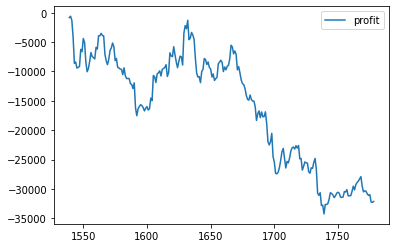

In [ ]:
x = test.tail(-27)
x['sign'] = x['sign'].replace([0, 1], [-1, 1])
x['body'] = np.abs(x['body'])
x['predicted'] = predicted_sign
x['predicted'] = x['predicted'].replace([0, 1], [-1, 1])
x['profit'] = x['predicted']*x['sign']*x['body']
x['profit'].tail(1000).sum()
# x['profit'].plot()
pd.DataFrame(np.cumsum(x['profit'])).plot()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

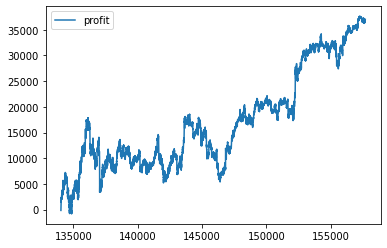

In [ ]:
x = test.tail(-2)
x['sign'] = x['sign'].replace([0, 1], [-1, 1])
x['body'] = np.abs(x['body'])
x['predicted'] = predicted_sign
x['predicted'] = x['predicted'].replace([0, 1], [-1, 1])
x['profit'] = x['predicted']*x['sign']*x['body']
x['profit'].tail(1000).sum()
# x['profit'].plot()
pd.DataFrame(np.cumsum(x['profit'])).plot()


In [ ]:
x = test.tail(-2)
x['sign'] = x['sign'].replace([0, 1], [-1, 1])
x['body'] = np.abs(x['body'])
x['predicted'] = predicted_sign
x['predicted'] = x['predicted'].replace([0, 1], [-1, 1])
x['profit'] = x['predicted']*x['sign']*x['body']
x['profit'].tail(1000).sum()
# x['profit'].plot()
pd.DataFrame(np.cumsum(x['profit'])).plot()


In [ ]:
x = test.tail(-2)
x['sign'] = x['sign'].replace([0, 1], [-1, 1])
x['body'] = np.abs(x['body'])
x['predicted'] = predicted_sign
x['predicted'] = x['predicted'].replace([0, 1], [-1, 1])
x['profit'] = x['predicted']*x['sign']*x['body']
x['profit'].tail(1000).sum()
# x['profit'].plot()
pd.DataFrame(np.cumsum(x['profit'])).plot()


In [ ]:
x['profit'].sum()

# x['profit'].argmax()
# x.head(70)

In [ ]:
x.head(60)
x.rolling(2).mean()['predicted'].value_counts(0)
# x.head(60)

In [ ]:
x['Close'].mean()*2000*0.0001

### Momentum Patterns with RSI


In [ ]:
# df = df.drop(columns=['index'])
# df['zigzag_5'] = df['zigzag_5'].replace(['L', 'S'], [1, 0])

df.head(60).columns
df['rsi_3'] = df['rsi_3'] - 50
df['rsi_5'] = df['rsi_5'] - 50
# df['rsi_10'] = df['rsi_10'] - 50
# df['rsi_15'] = df['rsi_15'] - 50
# df['rsi_20'] = df['rsi_20'] - 50
df['rsi_30'] = df['rsi_30'] - 50
df['rsi_60'] = df['rsi_60'] - 50
# df['rsi_90'] = df['rsi_90'] - 50
df['rsi_120'] = df['rsi_120'] - 50
# df['rsi_180'] = df['rsi_180'] - 50
df['rsi_240'] = df['rsi_240'] - 50
df['rsi_360'] = df['rsi_360'] - 50
df['rsi_480'] = df['rsi_480'] - 50
df['rsi_720'] = df['rsi_720'] - 50



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, svd_solver='full')
rsi_df = df.filter(items=['rsi_3', 'rsi_5', 'rsi_10', 'rsi_20', 'rsi_30', 'rsi_60', 'rsi_90', 'rsi_120', 'rsi_180', 'rsi_240', 'rsi_360', 'rsi_480', 'rsi_720', 'FISHERT_9_1', 'FISHERTs_9_1'])
# rsi_df = df.filter(items=['rsi_3', 'rsi_5', 'rsi_15', 'rsi_30', 'rsi_60', 'rsi_120', 'rsi_240', 'rsi_360', 'rsi_480', 'rsi_720'])

modified_df = df.drop(columns=['rsi_3', 'rsi_5', 'rsi_10', 'rsi_20', 'rsi_30', 'rsi_60', 'rsi_90', 'rsi_120', 'rsi_180', 'rsi_240', 'rsi_360', 'rsi_480', 'rsi_720', 'FISHERT_9_1', 'FISHERTs_9_1'])
tic = time.time()
pca.fit(rsi_df.head(-7500))
tac =  time.time()
print(tac - tic)
print(rsi_df)
rsi_df = pd.DataFrame(pca.transform(rsi_df))
rsi_df.columns=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
rsi_df
modified_df['feature_1'] = rsi_df['feature_1']
modified_df['feature_2'] = rsi_df['feature_2']
modified_df['feature_3'] = rsi_df['feature_3']
modified_df['feature_4'] = rsi_df['feature_4']
modified_df['feature_5'] = rsi_df['feature_5']
modified_df = modified_df.dropna()
modified_df

0.5797810554504395
           rsi_3     rsi_5    rsi_10    rsi_20    rsi_30    rsi_60   rsi_90  \
0      -29.30688 -13.12889  78.43258  93.81579  41.55856  30.52715  66.0116   
1      -29.30688  -4.68558  92.85810  93.81579  41.55856  30.52715  66.0116   
2      -29.30688  -4.68558  92.85810  93.81579  41.55856  30.52715  66.0116   
3      -43.34996  -4.68558  92.85810  93.81579  41.55856  30.52715  66.0116   
4      -43.34996  -4.68558  92.85810  93.81579  41.55856  30.52715  66.0116   
...          ...       ...       ...       ...       ...       ...      ...   
517248 -75.71622 -95.62864  13.90129  43.12661  36.05728  -2.43911  60.9610   
517249 -75.71622 -95.62864  13.90129  43.12661  36.05728  -2.43911  60.9610   
517250 -75.71622 -95.62864  13.90129  43.12661  36.05728  -2.43911  60.9610   
517251 -78.60630 -97.24818   5.61098  21.10543 -22.21253 -23.41616  60.9610   
517252 -78.60630 -97.24818   5.61098  21.10543 -22.21253 -23.41616  60.9610   

        rsi_120   rsi_180   rsi_

timestamp  open_price  high_price  low_price  close_price  \
0       2021-05-29 00:08:00    35815.50    35835.69   35750.00     35808.55   
1       2021-05-29 00:09:00    35801.95    35813.00   35750.20     35806.22   
2       2021-05-29 00:10:00    35806.22    35808.73   35711.96     35787.99   
3       2021-05-29 00:11:00    35790.66    35790.66   35739.72     35774.40   
4       2021-05-29 00:12:00    35776.59    35851.40   35774.85     35795.60   
...                     ...         ...         ...        ...          ...   
517248  2022-05-23 04:56:00    30116.00    30120.40   30108.00     30120.40   
517249  2022-05-23 04:57:00    30120.40    30128.40   30117.20     30128.00   
517250  2022-05-23 04:58:00    30128.10    30128.10   30122.00     30123.80   
517251  2022-05-23 04:59:00    30123.80    30128.90   30117.80     30117.80   
517252  2022-05-23 05:00:00    30117.80    30131.90   30100.00     30119.90   

         volume   body  sign   rsi_40   rsi_300  ...  zigzag_5  zigzag_10  \
0       446.781  -6.95     0  89.5378   1.11904  ...         1          0   
1       299.757   4.27     1  89.5378   1.11904  ...         1          0   
2       398.984 -18.23     0  89.5378   1.11904  ...         1          0   
3       305.260 -16.26     0  89.5378   1.11904  ...         1          0   
4       449.591  19.01     1  89.5378   1.11904  ...         1          0   
...         ...    ...   ...      ...       ...  ...       ...        ...   
517248  131.223   4.40     1  63.9465  96.58719  ...         1          0   
517249   62.866   7.60     1  63.9465  96.58719  ...         1          0   
517250   36.446  -4.30     0  63.9465  96.58719  ...         1          0   
517251   55.399  -6.00     0  63.9465  96.58719  ...         1          0   
517252  198.601   2.10     1  63.9465  96.58719  ...         1          S   

        zigzag_15  zigzag_20  zigzag_25  feature_1  feature_2  feature_3  \
0               0          0          0   10.79082  103.53418  -11.94738   
1               0          0          0    9.68615  112.22931   -3.20103   
2               0          0          0    9.68629  112.22661   -3.20612   
3               0          0          0    9.86084  109.13380   -9.13611   
4               0          0          0    9.86044  109.14119   -9.12210   
...           ...        ...        ...        ...        ...        ...   
517248          0          0          0  -53.89913  -56.60789  -14.98346   
517249          0          0          0  -53.89898  -56.61000  -14.98695   
517250          0          0          0  -53.89940  -56.60221  -14.97225   
517251          0          0          0  -34.99768 -101.22024   -6.20430   
517252          L          L          L  -34.99793 -101.21596   -6.19650   

        feature_4  feature_5  
0        10.74007   -1.65868  
1        11.63742    4.59695  
2        11.63252    4.59925  
3         5.05468   10.64546  
4         5.06829   10.63886  
...           ...        ...  
517248  -57.05587  -27.19626  
517249  -57.05847  -27.19654  
517250  -57.04428  -27.20323  
517251  -27.91559  -13.22546  
517252  -27.90854  -13.22787  

[517253 rows x 36 columns]

In [ ]:
rsi_df.head(-7500)


feature_1  feature_2  feature_3  feature_4  feature_5
0         98.08668   52.66469  -18.15795   -9.86652   10.14790
1         98.08668   52.66469  -18.15795   -9.86652   10.14790
2         98.08933   52.65282  -18.17801   -9.83875   10.16032
3        100.02143   43.29480  -34.38080   15.09752   28.03236
4        100.02143   43.29480  -34.38080   15.09752   28.03236
...            ...        ...        ...        ...        ...
1278031   98.08364    0.41670  -40.42217   54.38012   -0.63387
1278032   98.08390    0.41597  -40.42177   54.37715   -0.63928
1278033   95.10334   14.85302  -15.42380   15.90204  -28.22058
1278034   95.10068   14.86490  -15.40373   15.87427  -28.23299
1278035   94.61492   16.99383  -12.71032   13.08455  -28.33383

[1278036 rows x 5 columns]

In [ ]:
train, test = train_test_split(df.tail(50000), test_size=0.15, random_state=42, shuffle=False)
train

Time     Open     High      Low    Close  Volume  \
1235536  2022-05-11 13:40:00  29808.0  29867.0  29661.0  29724.0   470.0   
1235537  2022-05-11 13:41:00  29735.0  30022.0  29704.0  29989.0   396.0   
1235538  2022-05-11 13:42:00  29989.0  30074.0  29897.0  29974.0   378.0   
1235539  2022-05-11 13:43:00  29978.0  30120.0  29965.0  30108.0   356.0   
1235540  2022-05-11 13:44:00  30108.0  30734.0  30061.0  30607.0   780.0   
...                      ...      ...      ...      ...      ...     ...   
1278031  2022-06-10 01:55:00  29884.0  29907.0  29884.0  29907.0    17.0   
1278032  2022-06-10 01:56:00  29907.0  29948.0  29907.0  29948.0    43.0   
1278033  2022-06-10 01:57:00  29948.0  29948.0  29922.0  29930.0    31.0   
1278034  2022-06-10 01:58:00  29930.0  29937.0  29928.0  29928.0    12.0   
1278035  2022-06-10 01:59:00  29928.0  29928.0  29866.0  29886.0    32.0   

          body  sign  rsi_3  rsi_5  ...  rsi_90  rsi_120  rsi_180  rsi_240  \
1235536  -83.0     0  -31.0  -33.0  ...    11.0    -84.0     23.0    -90.0   
1235537  254.0     1  -31.0  -33.0  ...    11.0    -84.0     23.0    -90.0   
1235538  -15.0     0  -16.0  -33.0  ...    11.0    -84.0     23.0    -90.0   
1235539  130.0     1  -16.0  -33.0  ...    11.0    -84.0     23.0    -90.0   
1235540  499.0     1  -16.0   -8.0  ...    11.0    -84.0     23.0    -90.0   
...        ...   ...    ...    ...  ...     ...      ...      ...      ...   
1278031   23.0     1  -97.0  -94.0  ...    15.0    -90.0      6.0    -89.0   
1278032   40.0     1  -97.0  -94.0  ...    15.0    -90.0      6.0    -89.0   
1278033  -17.0     0  -26.0  -94.0  ...    15.0    -90.0      6.0    -89.0   
1278034   -3.0     0  -26.0  -94.0  ...    15.0    -90.0      6.0    -89.0   
1278035  -42.0     0  -26.0  -87.0  ...    15.0    -90.0      6.0    -89.0   

         rsi_360  rsi_480  rsi_720  zigzag_5  FISHERT_9_1  FISHERTs_9_1  
1235536    -97.0    -83.0    -88.0         1         -1.0          -1.0  
1235537    -97.0    -83.0    -88.0         1         -0.0          -1.0  
1235538    -97.0    -83.0    -88.0         1          0.0          -0.0  
1235539    -97.0    -83.0    -88.0         1          1.0           0.0  
1235540    -97.0    -83.0    -88.0         1          1.0           1.0  
...          ...      ...      ...       ...          ...           ...  
1278031    -94.0    -59.0    -79.0         1         -1.0          -0.0  
1278032    -94.0    -59.0    -79.0         1         -0.0          -1.0  
1278033    -94.0    -59.0    -79.0         1          0.0          -0.0  
1278034    -94.0    -59.0    -79.0         1          1.0           0.0  
1278035    -94.0    -59.0    -79.0         1          0.0           1.0  

[42500 rows x 25 columns]

In [ ]:
train, test = train_test_split(modified_df.tail(50000), test_size=0.15, random_state=42, shuffle=False)
# train, test = train_test_split(df, test_size=0.15, random_state=42, shuffle=False)
# test = test.dropna()
# train = df
look_back = 1
##########################################################################################
# dataX, dataY = [], []
# for i in range(train.shape[0]-look_back-1):
#     c = train['body'].iloc[i:(i+look_back)]
#     dataX.append(c)
#     dataY.append(train['sign'].iloc[i + look_back])
# x_train = np.array(dataX)
# y_train = np.array(dataY)

# dataX, dataY = [], []
# for i in range(test.shape[0]-look_back-1):
#     c = test['body'].iloc[i:(i+look_back)]
#     dataX.append(c)
#     dataY.append(test['sign'].iloc[i + look_back])
# x_test = np.array(dataX)
# y_test = np.array(dataY)
##########################################################################################

dataX, dataY = [], []
for i in range(train.shape[0]-look_back-1):
    c1 = train['body'].iloc[i:(i+look_back)]
    c2 = train['feature_1'].iloc[i:(i+look_back)]
    c3 = train['feature_2'].iloc[i:(i+look_back)]
    c4 = train['feature_3'].iloc[i:(i+look_back)]
    c5 = train['feature_4'].iloc[i:(i+look_back)]

#     c1 = train['body'].iloc[i:(i+look_back)]
#     c2 = train['rsi_5'].iloc[i:(i+look_back)]
#     c3 = train['FISHERT_9_1'].iloc[i:(i+look_back)]
#     c4 = train['FISHERTs_9_1'].iloc[i:(i+look_back)]
#     c5 = train['rsi_10'].iloc[i:(i+look_back)]
#     c6 = train['rsi_30'].iloc[i:(i+look_back)]
#     c7 = train['rsi_90'].iloc[i:(i+look_back)]
#     c8 = train['rsi_180'].iloc[i:(i+look_back)]
#     c9 = train['rsi_240'].iloc[i:(i+look_back)]
#     c10 = train['rsi_360'].iloc[i:(i+look_back)]
#     c11 = train['rsi_480'].iloc[i:(i+look_back)]
#     c12 = train['rsi_720'].iloc[i:(i+look_back)]
    dataX.append(np.array([c1, c2, c3, c4, c5]))#, c4, c5, c6, c7, c8, c9, c10, c11, c12]))
    dataY.append(train['zigzag_5'].iloc[i + look_back])
x_train = np.array(dataX)
y_train = np.array(dataY)

dataX, dataY = [], []
for i in range(test.shape[0]-look_back-1):
    c1 = test['body'].iloc[i:(i+look_back)]
    c2 = test['feature_1'].iloc[i:(i+look_back)]
    c3 = test['feature_2'].iloc[i:(i+look_back)]
    c4 = test['feature_3'].iloc[i:(i+look_back)]
    c5 = test['feature_4'].iloc[i:(i+look_back)]

#     c1 = train['body'].iloc[i:(i+look_back)]
#     c2 = train['rsi_5'].iloc[i:(i+look_back)]
#     c3 = train['FISHERT_9_1'].iloc[i:(i+look_back)]
#     c4 = train['FISHERTs_9_1'].iloc[i:(i+look_back)]
#     c5 = train['rsi_10'].iloc[i:(i+look_back)]
#     c6 = train['rsi_30'].iloc[i:(i+look_back)]
#     c7 = train['rsi_90'].iloc[i:(i+look_back)]
#     c8 = train['rsi_180'].iloc[i:(i+look_back)]
#     c9 = train['rsi_240'].iloc[i:(i+look_back)]
#     c10 = train['rsi_360'].iloc[i:(i+look_back)]
#     c11 = train['rsi_480'].iloc[i:(i+look_back)]
#     c12 = train['rsi_720'].iloc[i:(i+look_back)]
    dataX.append(np.array([c1, c2, c3, c4, c5]))#, c4, c5, c6, c7, c8, c9, c10, c11, c12]))
    dataY.append(test['zigzag_5'].iloc[i + look_back])
x_test = np.array(dataX)
y_test = np.array(dataY)

# x_train = tf.convert_to_tensor(np.reshape(x_train, (x_train.shape[0], 8, x_train.shape[1])))
# x_test = tf.convert_to_tensor(np.reshape(x_test, (x_test.shape[0], 8, x_test.shape[1])))
y_train = tf.convert_to_tensor(y_train.reshape((y_train.size, 1)))
y_test = tf.convert_to_tensor(y_test.reshape((y_test.size, 1)))

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
# y_train = tf.convert_to_tensor(y_train)
# y_test = tf.convert_to_tensor(y_test)


In [ ]:
# print(y_train[0:10])
# x_train
train

Time     Open     High      Low    Close  Volume  \
1235536  2022-05-11 13:40:00  29808.0  29867.0  29661.0  29724.0   470.0   
1235537  2022-05-11 13:41:00  29735.0  30022.0  29704.0  29989.0   396.0   
1235538  2022-05-11 13:42:00  29989.0  30074.0  29897.0  29974.0   378.0   
1235539  2022-05-11 13:43:00  29978.0  30120.0  29965.0  30108.0   356.0   
1235540  2022-05-11 13:44:00  30108.0  30734.0  30061.0  30607.0   780.0   
...                      ...      ...      ...      ...      ...     ...   
1278031  2022-06-10 01:55:00  29884.0  29907.0  29884.0  29907.0    17.0   
1278032  2022-06-10 01:56:00  29907.0  29948.0  29907.0  29948.0    43.0   
1278033  2022-06-10 01:57:00  29948.0  29948.0  29922.0  29930.0    31.0   
1278034  2022-06-10 01:58:00  29930.0  29937.0  29928.0  29928.0    12.0   
1278035  2022-06-10 01:59:00  29928.0  29928.0  29866.0  29886.0    32.0   

          body  sign  zigzag_5  feature_1  feature_2  feature_3  feature_4  \
1235536  -83.0     0         1  116.01382   17.24675   17.93671  -30.53582   
1235537  254.0     1         1  116.01116   17.25862   17.95677  -30.56359   
1235538  -15.0     0         1  115.37917   20.31864   23.25354  -38.71170   
1235539  130.0     1         1  115.37651   20.33052   23.27361  -38.73947   
1235540  499.0     1         1  101.40145   62.91203   44.21924  -35.10084   
...        ...   ...       ...        ...        ...        ...        ...   
1278031   23.0     1         1   98.08364    0.41670  -40.42217   54.38012   
1278032   40.0     1         1   98.08390    0.41597  -40.42177   54.37715   
1278033  -17.0     0         1   95.10334   14.85302  -15.42380   15.90204   
1278034   -3.0     0         1   95.10068   14.86490  -15.40373   15.87427   
1278035  -42.0     0         1   94.61492   16.99383  -12.71032   13.08455   

         feature_5  
1235536   14.41498  
1235537   14.40257  
1235538    8.57001  
1235539    8.55760  
1235540   25.84876  
...            ...  
1278031   -0.63387  
1278032   -0.63928  
1278033  -28.22058  
1278034  -28.23299  
1278035  -28.33383  

[42500 rows x 14 columns]

In [ ]:
features = 5
model = Sequential()
model.add(LSTM(15, input_shape=(features, look_back), return_sequences=True, activation = 'tanh', stateful=False))
# model.add(LSTM(15, return_sequences=True, activation = 'tanh', stateful=False))
model.add(Dropout(0.01))
model.add(Dense(units=5, activation='relu'))
model.add(LSTM(15, return_sequences=False, activation = 'tanh', stateful=False))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=2)) 
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True))
history = model.fit(x_train, y_train, epochs=300, batch_size=100, verbose=1)
model.save_weights('HM_Model_v7.2.4_ensamble_8.h5')
# print(model.evaluate(x=x_test, y=y_test, batch_size=10, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=8, use_multiprocessing=False))
y_predict = model.predict(x_test, batch_size=10, workers=8, use_multiprocessing=True)
# y_predict = y_predict.reshape((y_predict.shape[0], y_predict.shape[1]))
# y_predict


Epoch 1/300
425/425 [==============================] - 4s 4ms/step - loss: 0.6577
Epoch 2/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6433
Epoch 3/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6367
Epoch 4/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6303
Epoch 5/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6260
Epoch 6/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6227
Epoch 7/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6214
Epoch 8/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6200
Epoch 9/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6193
Epoch 10/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6186
Epoch 11/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6175
Epoch 12/300
425/425 [==============================] - 2s 4ms/step - loss: 0.6172
Epoch 13/300


425/425 [==============================] - 2s 4ms/step - loss: 0.5743
Epoch 100/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5739
Epoch 101/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5729
Epoch 102/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5731
Epoch 103/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5725
Epoch 104/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5729
Epoch 105/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5722
Epoch 106/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5720
Epoch 107/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5709
Epoch 108/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5706
Epoch 109/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5705
Epoch 110/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5697
Epoch 

425/425 [==============================] - 2s 4ms/step - loss: 0.5440
Epoch 197/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5427
Epoch 198/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5435
Epoch 199/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5416
Epoch 200/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5422
Epoch 201/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5431
Epoch 202/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5411
Epoch 203/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5414
Epoch 204/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5415
Epoch 205/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5421
Epoch 206/300
425/425 [==============================] - 2s 5ms/step - loss: 0.5417
Epoch 207/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5411
Epoch 

425/425 [==============================] - 2s 4ms/step - loss: 0.5233
Epoch 294/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5234
Epoch 295/300
425/425 [==============================] - 2s 5ms/step - loss: 0.5237
Epoch 296/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5226
Epoch 297/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5234
Epoch 298/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5227
Epoch 299/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5249
Epoch 300/300
425/425 [==============================] - 2s 4ms/step - loss: 0.5235


In [ ]:
print(model.evaluate(x=x_test, y=y_test, batch_size=10, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=8, use_multiprocessing=False))
# for y in y_predict:
#     print(y)
y_predict = model.predict(x_test, batch_size=10, workers=8, use_multiprocessing=True)


750/750 [==============================] - 1s 1ms/step - loss: 0.7524
0.7524245977401733


In [ ]:
predicted_sign = []
for y in y_predict:
    if np.exp(y[0])/sum(np.exp(y)) >= 0.5:
        predicted_sign.append(0)
    elif np.exp(y[0])/sum(np.exp(y)) < 0.5:
        predicted_sign.append(1)
        

In [ ]:
# len(predicted_sign)
# np.sum(predicted_sign)
accuracy_score(predicted_sign, y_test)
# predicted_sign

0.5857562016537743

<ipython-input-29-d9b448652360>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sign'] = x['sign'].replace([0, 1], [1, -1])
<ipython-input-29-d9b448652360>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['body'] = np.abs(x['body'])
<ipython-input-29-d9b448652360>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<AxesSubplot:>

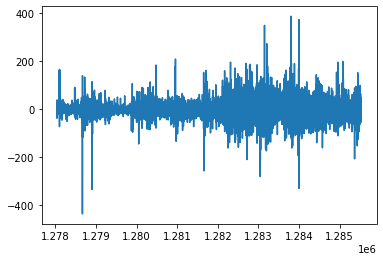

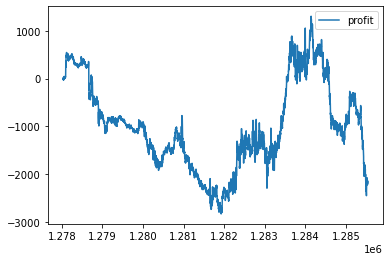

In [ ]:
x = test.tail(-2)
x['sign'] = x['sign'].replace([0, 1], [1, -1])
x['body'] = np.abs(x['body'])
x['predicted'] = predicted_sign
x['predicted'] = x['predicted'].replace([0, 1], [1, -1])
x['profit'] = x['predicted']*x['sign']*x['body']
x['profit'].tail(1000).sum()
# x['profit'].plot()
pd.DataFrame(np.cumsum(x['profit'])).plot()

In [ ]:
acuracy = []
features = 5

for t in range(100):
    model = Sequential()
    model.add(LSTM(15, input_shape=(features, look_back), return_sequences=True, activation = 'tanh', stateful=False))
    # model.add(LSTM(15, return_sequences=True, activation = 'tanh', stateful=False))
    model.add(Dropout(0.01))
    model.add(Dense(units=5, activation='relu'))
    model.add(LSTM(15, return_sequences=False, activation = 'tanh', stateful=False))
    model.add(Dense(units=10, activation='relu'))
    model.add(Dense(units=2)) 
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True))
    history = model.fit(x_train, y_train, epochs=50, batch_size=500, verbose=0)
    model.save_weights('Hamiltonian_Model_v7.2.4_ensamble_8.h5')
    # print(model.evaluate(x=x_test, y=y_test, batch_size=10, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=8, use_multiprocessing=False))
    y_predict = model.predict(x_test, batch_size=10, workers=8, use_multiprocessing=True)
    # y_predict = y_predict.reshape((y_predict.shape[0], y_predict.shape[1]))
    # y_predict
#     print(model.evaluate(x=x_test, y=y_test, batch_size=10, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=8, use_multiprocessing=False))
    # for y in y_predict:
    #     print(y)
    y_predict = model.predict(x_test, batch_size=10, workers=8, use_multiprocessing=True)
    predicted_sign = []
    for y in y_predict:
        if np.exp(y[0])/sum(np.exp(y)) >= 0.5:
            predicted_sign.append(0)
        elif np.exp(y[0])/sum(np.exp(y)) < 0.5:
            predicted_sign.append(1)
    x = test.tail(-2)
    x['sign'] = x['sign'].replace([0, 1], [-1, 1])
    x['body'] = np.abs(x['body'])
    x['predicted'] = predicted_sign
    x['predicted'] = x['predicted'].replace([0, 1], [-1, 1])
    x['profit'] = x['predicted']*x['sign']*x['body']
    acuracy.append(accuracy_score(predicted_sign, y_test))
    print(accuracy_score(predicted_sign, y_test), x['profit'].sum())


In [ ]:
x.tail(60)

timestamp  open_price  high_price  low_price  close_price  \
521212  2022-05-23 03:51:00     30165.0     30167.0    30156.0      30164.0   
521213  2022-05-23 03:52:00     30163.0     30163.0    30159.0      30159.0   
521214  2022-05-23 03:53:00     30159.0     30168.0    30147.0      30164.0   
521215  2022-05-23 03:54:00     30164.0     30175.0    30156.0      30156.0   
521216  2022-05-23 03:55:00     30156.0     30160.0    30147.0      30149.0   
521217  2022-05-23 03:56:00     30149.0     30153.0    30147.0      30153.0   
521218  2022-05-23 03:57:00     30152.0     30153.0    30140.0      30143.0   
521219  2022-05-23 03:58:00     30143.0     30160.0    30137.0      30160.0   
521220  2022-05-23 03:59:00     30160.0     30168.0    30160.0      30165.0   
521221  2022-05-23 04:00:00     30165.0     30173.0    30146.0      30173.0   
521222  2022-05-23 04:01:00     30173.0     30175.0    30168.0      30175.0   
521223  2022-05-23 04:02:00     30175.0     30175.0    30163.0      30174.0   
521224  2022-05-23 04:03:00     30174.0     30186.0    30173.0      30183.0   
521225  2022-05-23 04:04:00     30183.0     30208.0    30183.0      30190.0   
521226  2022-05-23 04:05:00     30190.0     30214.0    30190.0      30206.0   
521227  2022-05-23 04:06:00     30206.0     30217.0    30204.0      30212.0   
521228  2022-05-23 04:07:00     30212.0     30212.0    30185.0      30193.0   
521229  2022-05-23 04:08:00     30193.0     30193.0    30190.0      30190.0   
521230  2022-05-23 04:09:00     30190.0     30208.0    30190.0      30200.0   
521231  2022-05-23 04:10:00     30200.0     30200.0    30185.0      30197.0   
521232  2022-05-23 04:11:00     30197.0     30235.0    30189.0      30227.0   
521233  2022-05-23 04:12:00     30227.0     30229.0    30206.0      30206.0   
521234  2022-05-23 04:13:00     30206.0     30208.0    30198.0      30201.0   
521235  2022-05-23 04:14:00     30201.0     30201.0    30184.0      30191.0   
521236  2022-05-23 04:15:00     30191.0     30198.0    30188.0      30195.0   
521237  2022-05-23 04:16:00     30195.0     30200.0    30195.0      30197.0   
521238  2022-05-23 04:17:00     30197.0     30200.0    30190.0      30200.0   
521239  2022-05-23 04:18:00     30200.0     30225.0    30191.0      30215.0   
521240  2022-05-23 04:19:00     30215.0     30229.0    30215.0      30228.0   
521241  2022-05-23 04:20:00     30228.0     30228.0    30208.0      30214.0   
521242  2022-05-23 04:21:00     30214.0     30214.0    30197.0      30203.0   
521243  2022-05-23 04:22:00     30203.0     30205.0    30189.0      30199.0   
521244  2022-05-23 04:23:00     30199.0     30217.0    30198.0      30215.0   
521245  2022-05-23 04:24:00     30215.0     30218.0    30206.0      30206.0   
521246  2022-05-23 04:25:00     30206.0     30215.0    30200.0      30208.0   
521247  2022-05-23 04:26:00     30208.0     30209.0    30189.0      30194.0   
521248  2022-05-23 04:27:00     30194.0     30199.0    30191.0      30199.0   
521249  2022-05-23 04:28:00     30199.0     30216.0    30199.0      30201.0   
521250  2022-05-23 04:29:00     30200.0     30208.0    30196.0      30204.0   
521251  2022-05-23 04:30:00     30204.0     30216.0    30204.0      30216.0   
521252  2022-05-23 04:31:00     30216.0     30225.0    30216.0      30223.0   
521253  2022-05-23 04:32:00     30223.0     30235.0    30217.0      30218.0   
521254  2022-05-23 04:33:00     30217.0     30217.0    30198.0      30202.0   
521255  2022-05-23 04:34:00     30202.0     30202.0    30183.0      30184.0   
521256  2022-05-23 04:35:00     30184.0     30196.0    30179.0      30194.0   
521257  2022-05-23 04:36:00     30194.0     30204.0    30190.0      30200.0   
521258  2022-05-23 04:37:00     30200.0     30212.0    30197.0      30212.0   
521259  2022-05-23 04:38:00     30212.0     30212.0    30185.0      30190.0   
521260  2022-05-23 04:39:00     30190.0     30190.0    30173.0      30173.0   
521261  2022-05-23 04:40:00     30173.0     30173.0    30156.0      

In [ ]:
print(np.max(acuracy))
print(np.min(acuracy))
print(np.mean(acuracy))
print(np.std(acuracy))

0.7990130701520406
0.7814083755668179
0.7912536676447053
0.003085948813026837


In [ ]:
acuracy


[0.7895438783675647,
 0.7919445185382769,
 0.789143771672446,
 0.7950120032008535,
 0.7907441984529208,
 0.7928781008268871,
 0.7942117898106161,
 0.7936783142171245,
 0.785142704721259,
 0.7932782075220058,
 0.79301146972526,
 0.7882101893838357,
 0.7922112563350227,
 0.7894105094691918,
 0.7916777807415311,
 0.787810082688717,
 0.7890104027740731,
 0.7955454787943451,
 0.7923446252333955,
 0.7924779941317684,
 0.7962123232862096,
 0.7907441984529208,
 0.7942117898106161,
 0.7926113630301413,
 0.7902107228594292,
 0.7888770338757002,
 0.7963456921845825,
 0.7968791677780741,
 0.7898106161643105,
 0.7919445185382769,
 0.7912776740464124,
 0.7875433448919712,
 0.7871432381968525,
 0.7882101893838357,
 0.7859429181114964,
 0.7852760736196319,
 0.7948786343024806,
 0.7910109362496666,
 0.7935449453187516,
 0.7923446252333955,
 0.7907441984529208,
 0.7935449453187516,
 0.7844758602293945,
 0.7920778874366498,
 0.7935449453187516,
 0.7976793811683115,
 0.7927447319285142,
 0.791010936249666

In [ ]:
print(np.max(acuracy))
print(np.min(acuracy))
print(np.mean(acuracy))
print(np.std(acuracy))
acuracy

0.8003467591357696
0.7792744731928515
0.7916724459855959
0.0036461173796713212


[0.7915444118431582,
 0.7792744731928515,
 0.7928781008268871,
 0.7906108295545479,
 0.794345158708989,
 0.794345158708989,
 0.790477460656175,
 0.8003467591357696,
 0.7922112563350227,
 0.7890104027740731,
 0.7955454787943451,
 0.7962123232862096,
 0.7915444118431582,
 0.7870098692984796,
 0.7874099759935983,
 0.7932782075220058,
 0.7911443051480395,
 0.7920778874366498,
 0.7844758602293945,
 0.7935449453187516,
 0.7972792744731928,
 0.7902107228594292,
 0.7827420645505468,
 0.7942117898106161,
 0.7902107228594292,
 0.7900773539610563,
 0.7942117898106161,
 0.7931448386236329,
 0.787810082688717,
 0.79301146972526,
 0.7871432381968525,
 0.7862096559082422,
 0.7903440917578021,
 0.785142704721259,
 0.7852760736196319,
 0.7927447319285142,
 0.7976793811683115,
 0.789143771672446,
 0.7919445185382769,
 0.7934115764203787,
 0.79301146972526,
 0.791811149639904,
 0.7938116831154974,
 0.7971459055748199,
 0.79301146972526,
 0.7947452654041077,
 0.789143771672446,
 0.7939450520138703,
 0.794